Loading Model


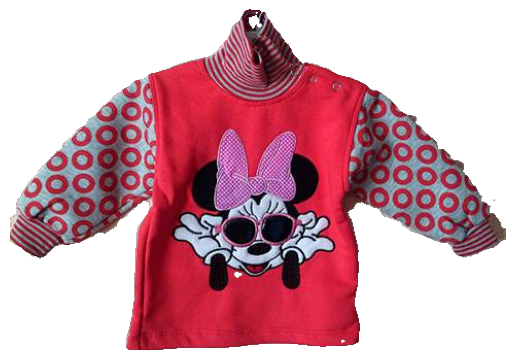

In [1]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
import base64


def clothes_segmentation(image_to_segment):
    print("Loading Model")

    processor = SegformerImageProcessor.from_pretrained("sayeed99/segformer_b3_clothes")
    model = AutoModelForSemanticSegmentation.from_pretrained("sayeed99/segformer_b3_clothes")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) # Move the model to the selected device

    # Open and preprocess the image
    image = Image.open(image_to_segment)
    inputs = processor(images=image, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model(**inputs)
    logits = outputs.logits

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    image.close()

    return upsampled_logits, model


def crop_clothes_from_fullbody(image_to_segment):
    upsampled_logits, model = clothes_segmentation(image_to_segment)

    image = Image.open(image_to_segment)

    # Get the segmentation map
    pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

    # Apply Softmax to get normalized probabilities for each class
    probabilities = nn.functional.softmax(upsampled_logits, dim=1)  # Apply Softmax along the class dimension

    # Check the % of certainty and filter results
    certainty_mask = probabilities.max(dim=1).values > 0.8  # Create a mask for probabilities > 80%
    
    # Get unique class labels present in the predicted segmentation map
    unique_labels = np.unique(certainty_mask.cpu().numpy())
    #unique_labels = np.unique(pred_seg)

    # Get the model's config which contains the id2label dictionary
    config = model.config

    if hasattr(config, 'id2label'):
        id2label = config.id2label
        
        # Map the unique labels to their class names
        identified_labels = {label: id2label[label] for label in unique_labels}
        
        print("Identified Labels in the Image:")
        for label_id, label_name in identified_labels.items():
            print(f"Class ID: {label_id}, Class Name: {label_name}")
            
            # Convert the segmentation map to a binary mask (assuming class 1 is the target segment)
            target_class = label_id # Change this to the class you want to extract
            binary_mask = (pred_seg == target_class).astype(np.uint8)

            # Find the bounding box of the target segment
            non_zero_indices = np.nonzero(binary_mask)
            if non_zero_indices[0].size == 0:
                continue
            min_y, max_y = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
            min_x, max_x = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

            # Crop the original image using the bounding box
            cropped_image = image.crop((min_x, min_y, max_x, max_y))

            img_bytes = cropped_image.tobytes()
            img_base64 = base64.b64decode(img_bytes)

            # Show the cropped image
            plt.imshow(cropped_image)
            plt.axis('off')
            plt.show()
    else:
        print("No class labels found in the model's configuration.")

    image.close()
    
def crop_clothes(image_to_segment):
    upsampled_logits, model = clothes_segmentation(image_to_segment)

    # Get the segmentation map
    pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

    # Get unique class labels present in the predicted segmentation map
    unique_labels, counts = np.unique(pred_seg, return_counts=True)

    # Create a dictionary to store label counts excluding label 0 (Background)
    label_counts = {label: count for label, count in 
                    zip(unique_labels, counts) if label != 0}

    # Get the label with the most values
    max_label = max(label_counts, key=label_counts.get)

    # Print the results
    # print(f"Label counts: {label_counts}")
    # print(f"Label with the most values: {max_label}, Count: {label_counts[max_label]}")

    image = Image.open(image_to_segment)

    # Convert the segmentation map to a binary mask 
    target_class = max_label
    binary_mask = (pred_seg == target_class).astype(np.uint8)

    # Create a blank (transparent) image with the same size as the original image
    cropped_image = Image.new("RGBA", image.size)

    # Apply the mask to the original image
    cropped_image = Image.composite(image.convert("RGBA"), 
                                    cropped_image, 
                                    Image.fromarray(binary_mask * 255))

    # Crop the image to remove excess transparent borders
    non_zero_indices = np.nonzero(binary_mask)
    min_y, max_y = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    min_x, max_x = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])
    cropped_image = cropped_image.crop((min_x, min_y, max_x, max_y))

    # Show the cropped image
    # plt.imshow(cropped_image)
    # plt.axis('off')
    # plt.show()

    image.close()

if __name__ == "__main__":
    crop_clothes('images/0c0bfbde088d5b2f94f10b47f5b6352c28cbc148.jpg')